In [1]:
%load_ext autoreload
%autoreload 2
import sys, os

In [2]:
import glob, os
import mediapy as media
import torch
from torch.utils.data import DataLoader

from load_model_from_ckpt import load_model, get_sampler, init_samples
from datasets import get_dataset, data_transform, inverse_data_transform
from runners.ncsn_runner import conditioning_fn

from os.path import expanduser
home = expanduser("~")

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
torch.cuda.is_available()

True

# Set directories to download model, data

In [3]:
# SET THESE!!!
GDRIVE_URL = "https://drive.google.com/drive/folders/1bM6wqU_kymoljz5uYQRCYNup_8adBfLH" # smmnist_big_5c5_unetm_b2
EXP_PATH = os.path.join(home, "DATA/MCVD_SMMNIST_pred/smmnist_big_c5t5_SPADE/logs")
DATA_PATH = os.path.join(home, "DATA/MNIST")

# Download experiment (model checkpoint, config, etc.)

In [4]:
# GDRIVE_URL = GDRIVE_URL.removesuffix("?usp=sharing")
# !gdown --fuzzy {GDRIVE_URL} -O {EXP_PATH}/ --folder

# Load model checkpoint

In [5]:
ckpt_path = glob.glob(os.path.join(EXP_PATH, "checkpoint_*.pt"))[0]
scorenet, config = load_model(ckpt_path, device)
sampler = get_sampler(config)

In [6]:
print(device)
print(ckpt_path)
print(config)

cuda
/home/matt/DATA/MCVD_SMMNIST_pred/smmnist_big_c5t5_SPADE/logs/checkpoint_140000.pt
Namespace(data=Namespace(channels=1, dataset='StochasticMovingMNIST', gaussian_dequantization=False, image_size=64, logit_transform=False, num_digits=2, num_frames=5, num_frames_cond=5, num_workers=0, prob_mask_cond=0.0, random_flip=True, rescaled=True, step_length=0.1, uniform_dequantization=False), fast_fid=Namespace(batch_size=1000, begin_ckpt=5000, end_ckpt=300000, ensemble=False, freq=5000, n_steps_each=0, num_samples=1000, pr_nn_k=3, step_lr=0.0, verbose=False), model=Namespace(arch='unetmore', attn_resolutions=[8, 16, 32], ch_mult=[1, 2, 3, 4], cond_emb=False, conditional=True, depth='deep', dropout=0.1, ema=True, ema_rate=0.999, gamma=False, gff=False, n_head_channels=64, ngf=64, noise_in_cond=False, nonlinearity='swish', normalization='InstanceNorm++', num_classes=1000, num_res_blocks=2, output_all_frames=False, sigma_begin=0.02, sigma_dist='linear', sigma_end=0.0001, spade=True, spec_norm=

# Load data

In [7]:
dataset, test_dataset = get_dataset(DATA_PATH, config, video_frames_pred=config.data.num_frames)

Dataset length: 60000
Dataset length: 256


In [8]:
# dataloader = DataLoader(dataset, batch_size=config.training.batch_size, shuffle=True,
#                         num_workers=config.data.num_workers)
# train_iter = iter(dataloader)
# x, y = next(train_iter)

test_loader = DataLoader(test_dataset, batch_size=config.training.batch_size, shuffle=False,
                         num_workers=config.data.num_workers, drop_last=True)
test_iter = iter(test_loader)
test_x, test_y = next(test_iter)
print(test_x.shape)

torch.Size([64, 10, 1, 64, 64])


In [9]:
test_x = data_transform(config, test_x)
real, cond, cond_mask = conditioning_fn(config, test_x, num_frames_pred=config.data.num_frames,
                                        prob_mask_cond=getattr(config.data, 'prob_mask_cond', 0.0),
                                        prob_mask_future=getattr(config.data, 'prob_mask_future', 0.0))
print(real.shape, cond.shape)

torch.Size([64, 5, 64, 64]) torch.Size([64, 5, 64, 64])


,,,,,,,,,

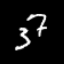
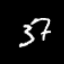
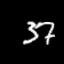
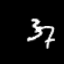
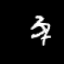
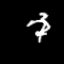
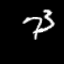
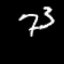
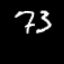
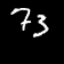

In [10]:
i = 1
# media.show_images(torch.cat([cond[i].permute(0, 2, 3, 1), real[i].permute(0, 2, 3, 1)]))
media.show_images(torch.cat([cond[i], real[i]]))

# Load initial samples

In [11]:
init = init_samples(len(real), config)

torch.Size([64, 5, 64, 64])


,,,,

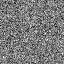
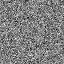
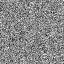
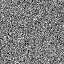
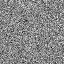

In [12]:
print(init.shape)
media.show_images(init[i])

# Predict

In [13]:
pred = sampler(init, scorenet, cond=cond, cond_mask=cond_mask, subsample=100, verbose=True)

/home/matt/anaconda3/envs/mcvd/lib/python3.12/site-packages/torch/utils/cpp_extension.py:2059: UserWarning: TORCH_CUDA_ARCH_LIST is not set, all archs for visible cards are included for compilation. 
If this is not desired, please set os.environ['TORCH_CUDA_ARCH_LIST'].
  warnings.warn(


DDPM: 1/100, grad_norm: 143.1108856201172, image_norm: 129.25294494628906, grad_mean_norm: 321.1800842285156
DDPM: 10/100, grad_norm: 143.24270629882812, image_norm: 130.6368408203125, grad_mean_norm: 324.1562805175781
DDPM: 20/100, grad_norm: 143.32928466796875, image_norm: 132.01754760742188, grad_mean_norm: 324.895751953125
DDPM: 30/100, grad_norm: 143.669921875, image_norm: 133.31887817382812, grad_mean_norm: 322.8755187988281
DDPM: 40/100, grad_norm: 144.85629272460938, image_norm: 134.44088745117188, grad_mean_norm: 318.96466064453125
DDPM: 50/100, grad_norm: 148.48971557617188, image_norm: 135.4327850341797, grad_mean_norm: 319.1570739746094
DDPM: 60/100, grad_norm: 158.0760498046875, image_norm: 136.42974853515625, grad_mean_norm: 320.1054382324219
DDPM: 70/100, grad_norm: 180.6873321533203, image_norm: 136.9653778076172, grad_mean_norm: 322.55450439453125
DDPM: 80/100, grad_norm: 235.598388671875, image_norm: 137.12551879882812, grad_mean_norm: 322.6925964355469
DDPM: 90/100, 

torch.Size([64, 5, 64, 64])


,,,,,,,,,

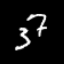
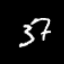
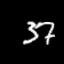
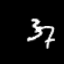
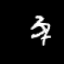
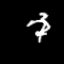
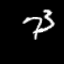
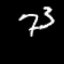
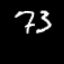
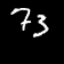

,,,,,,,,,

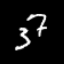
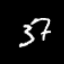
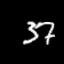
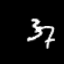
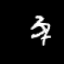
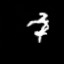
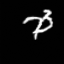
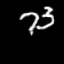
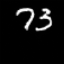
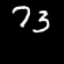

In [14]:
print(pred.shape)
i = 1
media.show_images(torch.cat([cond[i], real[i]]))
media.show_images(torch.cat([cond[i], pred[i]]))

,,,,,,,,,

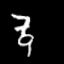
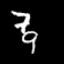
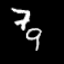
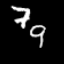
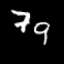
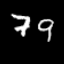
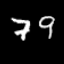
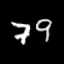
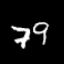
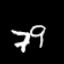

,,,,,,,,,

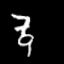
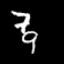
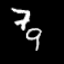
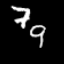
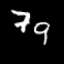
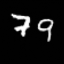
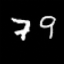
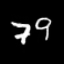
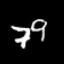
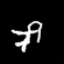

In [16]:
i = 4
media.show_images(torch.cat([cond[i], real[i]]))
media.show_images(torch.cat([cond[i], pred[i]]))